# Aim 1

## おまじないパート

In [1]:
import sys
from pathlib import Path

# 現在のノートブックのパスを取得
notebook_dir = Path().resolve() 

# プロジェクトルートディレクトリ（notebooksディレクトリの親ディレクトリ）を取得
# プロジェクトルートは2階層上です
project_root = notebook_dir.parent.parent

# プロジェクトルートをPythonの検索パスに追加
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
from groom import GroomAim1, GroomAim1LinearTests,\
    save_to_parquet, load_from_parquet, save_model, load_model

In [3]:
self = GroomAim1()

In [4]:
import pandas as pd

## BLと毛繕い行動との間に有意差があるか

### delta_dfの読み込み

In [5]:
raw_delta_df = load_from_parquet("../../data/preprocessed_data/temperature_delta_df.parquet")

--- 復元完了 ---
復元されたDataFrameのshape: (2625, 17)


### 初期300秒に限定

In [6]:
delta_df = raw_delta_df[(raw_delta_df['delta_time'] <= 300)].copy()

### 散布図の作成

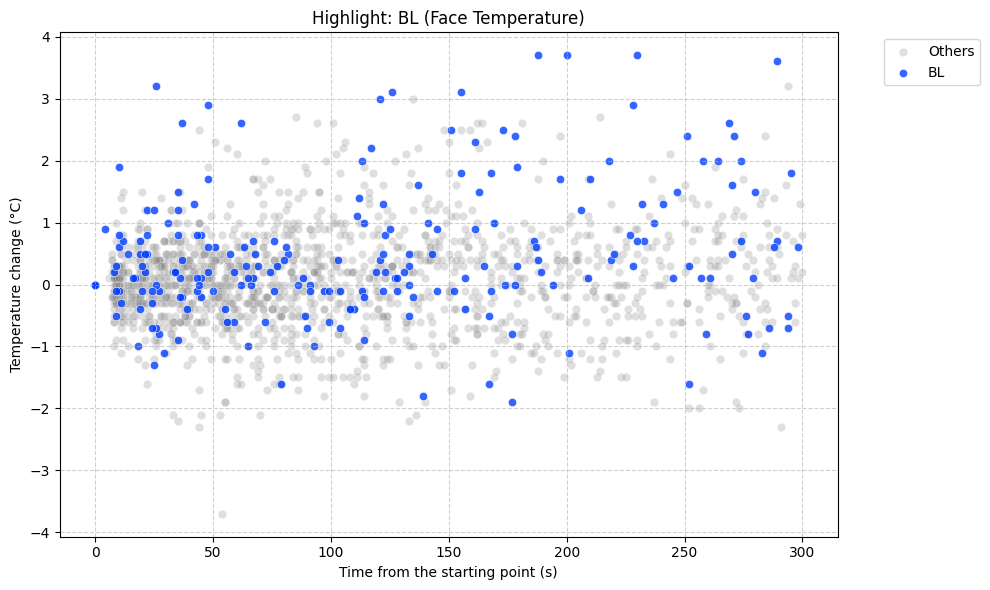

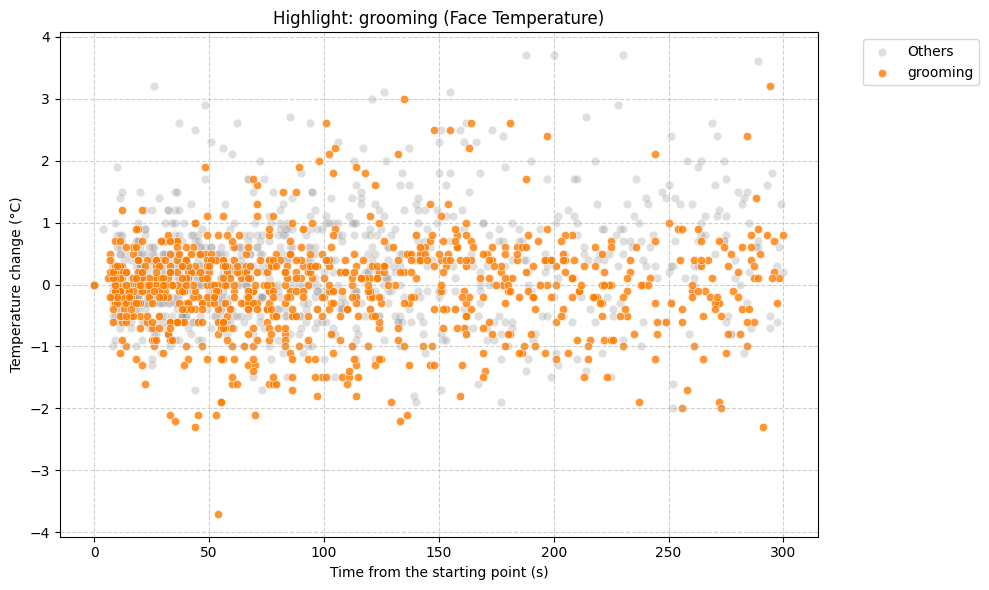

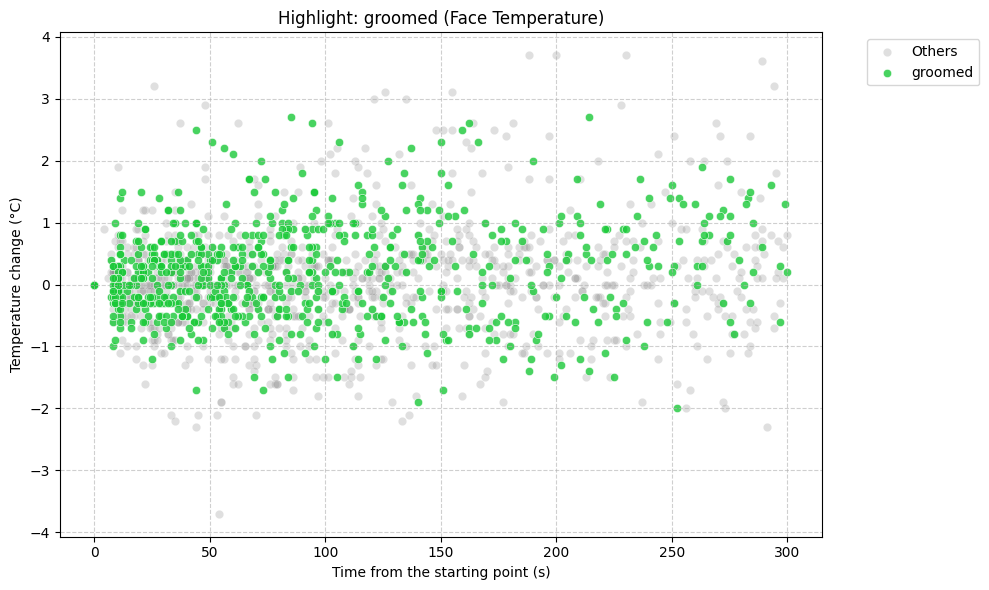

In [7]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_face')

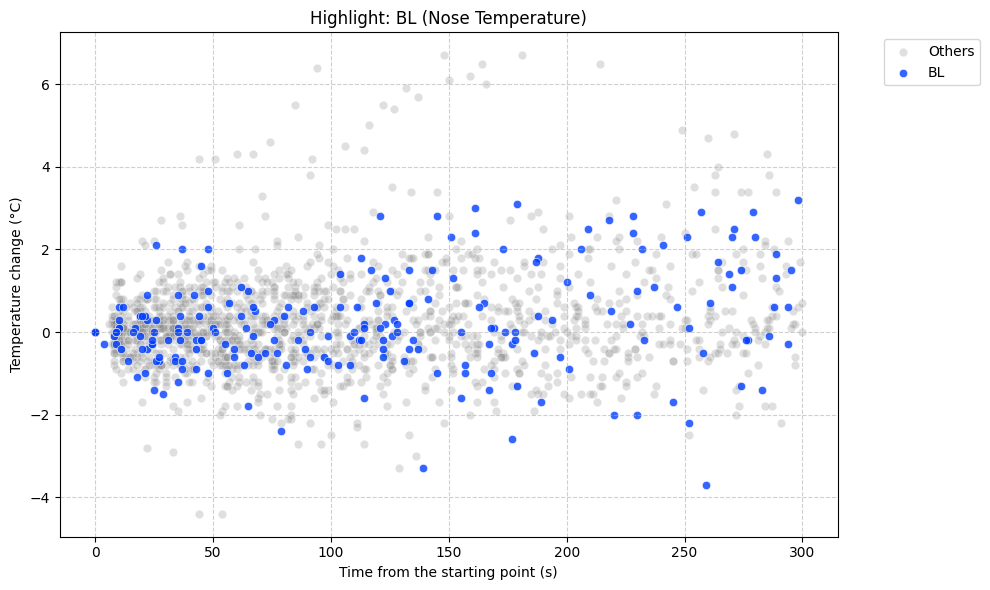

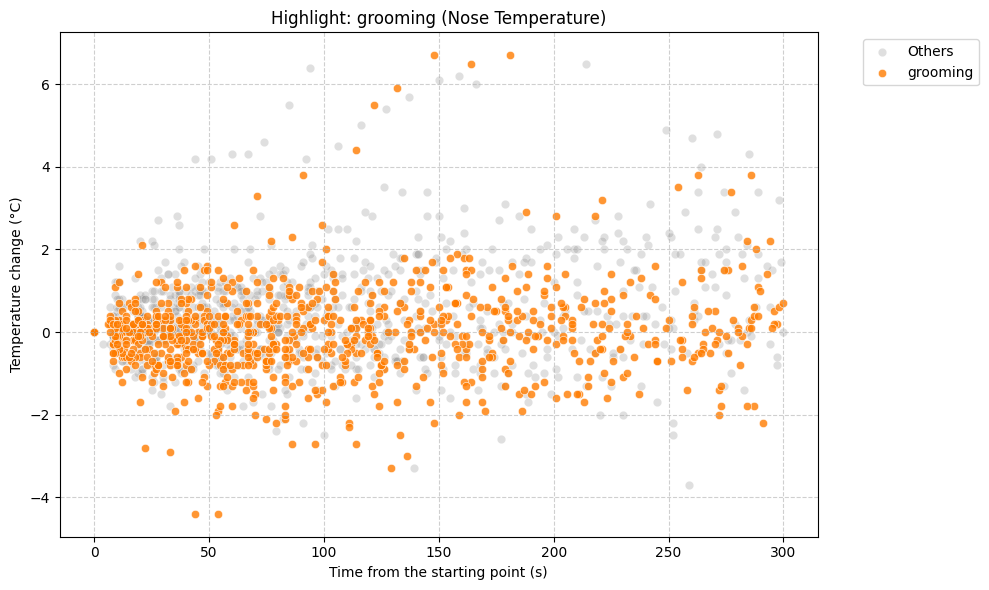

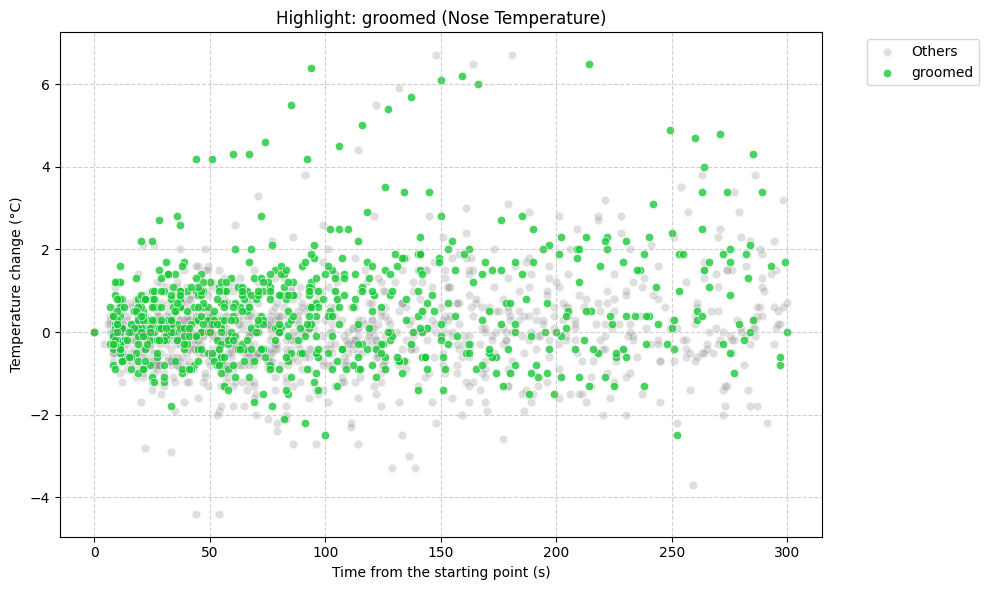

In [8]:
for behavior in delta_df['behavior'].unique():
    self.plot_highlight_behavior(delta_df, target_behavior=behavior, y_column='delta_nose')

### 平滑化トレンドのプロット

まずは1秒間隔のdfを作成

In [9]:
# 1. 内挿実行（一度だけでOK）
delta_df_1s = self.interpolate_samples(delta_df)

Interpolating 267 samples...


C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:113: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  resampled = resampled.interpolate(method='linear')
C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resampled = resampled.ffill().bfill()
C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:113: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  resampled = resampled.interpolate(method='linear')
C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:116: Fu

Interpolation completed.


C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resampled = resampled.ffill().bfill()
C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:113: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  resampled = resampled.interpolate(method='linear')
C:\Users\yyu33\Downloads\Monkey_Aggression\groom\aim1.py:116: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  resampled = resampled

In [10]:
print(delta_df_1s.shape)

(80367, 17)


In [11]:
print(delta_df_1s[delta_df_1s['sampling_id'] == 1].shape)

(301, 17)


csvで保存しておく

In [12]:
import pandas as pd
import os

def save_to_csv(df: pd.DataFrame, filename: str):
    """
    DataFrameをCSVファイルとして特定のディレクトリに保存します。
    """
    # 保存先のディレクトリパス
    save_dir = r"C:\Users\yyu33\Downloads\Monkey_Aggression\data\01_processed_data"
    
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        print(f"ディレクトリを作成しました: {save_dir}")
    
    # フルパスの構築
    full_path = os.path.join(save_dir, filename)
    
    # CSVとして保存（インデックスを含めるかどうかは用途に合わせて index=False で調整してください）
    delta_df.to_csv(full_path, index=False, encoding='utf-8-sig')
    
    print(f"--- CSV保存完了 ---")
    print(f"Path: {full_path}")
    print(f"ファイルサイズ: {os.path.getsize(full_path) / 1024:.2f} KB")

In [13]:
save_to_csv(delta_df_1s, 'delta_df_1s.csv')

--- CSV保存完了 ---
Path: C:\Users\yyu33\Downloads\Monkey_Aggression\data\01_processed_data\delta_df_1s.csv
ファイルサイズ: 209.08 KB


In [14]:
print(delta_df_1s.head(10))

   delta_time  sampling_id  t0_flag            datetime  delta_face  \
0           0            1      1.0 2025-04-20 08:48:50        0.00   
1           1            1      1.0 2025-04-20 08:48:51        0.06   
2           2            1      1.0 2025-04-20 08:48:52        0.12   
3           3            1      1.0 2025-04-20 08:48:53        0.18   
4           4            1      1.0 2025-04-20 08:48:54        0.24   
5           5            1      1.0 2025-04-20 08:48:55        0.30   
6           6            1      1.0 2025-04-20 08:48:56        0.36   
7           7            1      1.0 2025-04-20 08:48:57        0.42   
8           8            1      1.0 2025-04-20 08:48:58        0.48   
9           9            1      1.0 2025-04-20 08:48:59        0.54   

   delta_nose    name    id sex behavior   to from shade  kin  \
0        0.00  Takana  21.0   f       BL  NaN  NaN    no  NaN   
1        0.01  Takana  21.0   f       BL  NaN  NaN    no  NaN   
2        0.02  Takana  

#### face

全behaviorでの帯プロット

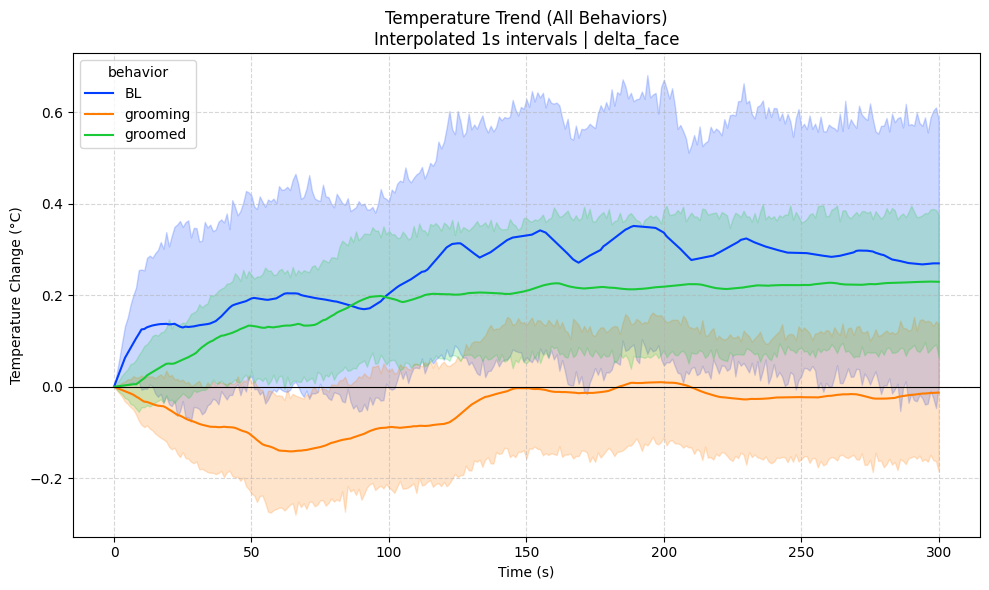

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face'
)

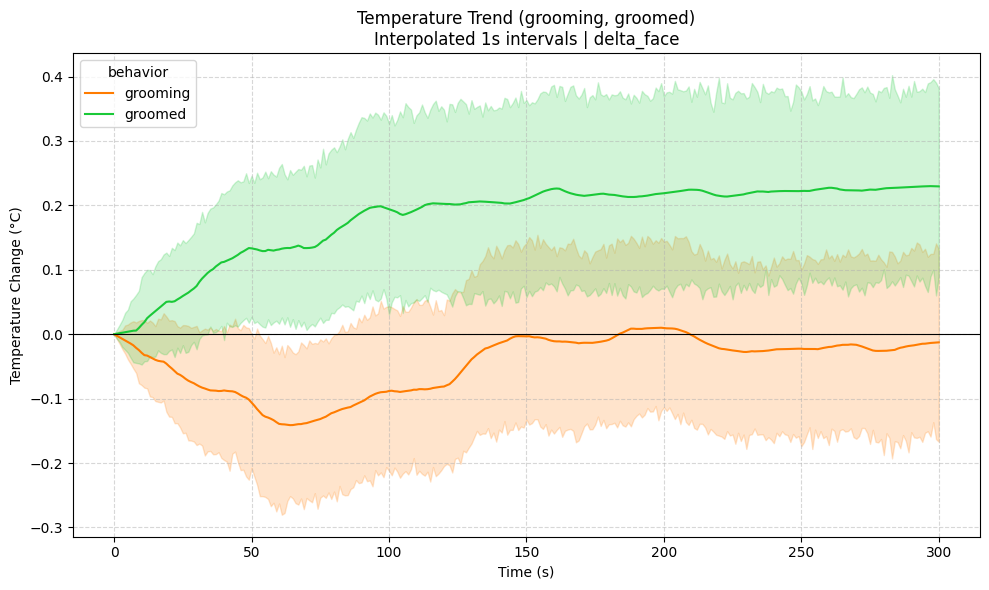

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face', target_behaviors=['grooming', 'groomed']
)

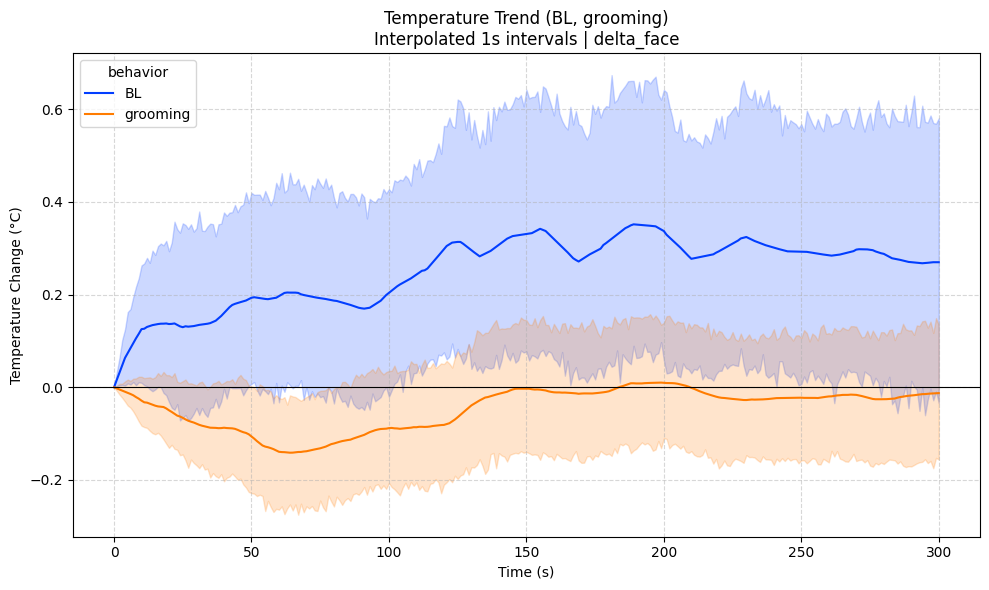

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_face', target_behaviors=['BL', 'grooming']
)

#### nose

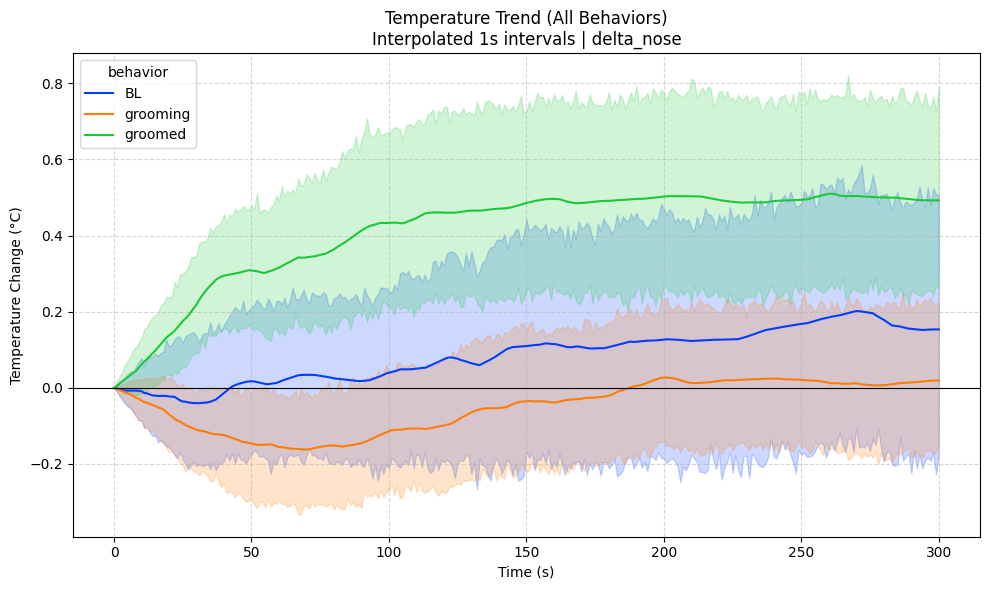

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose'
)

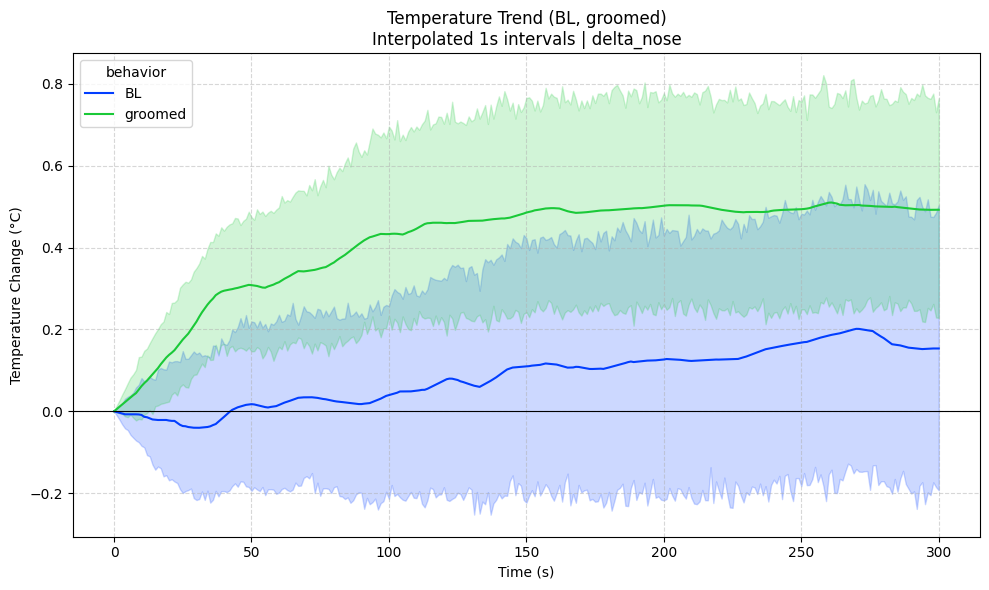

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose', target_behaviors=['BL', 'groomed']
)

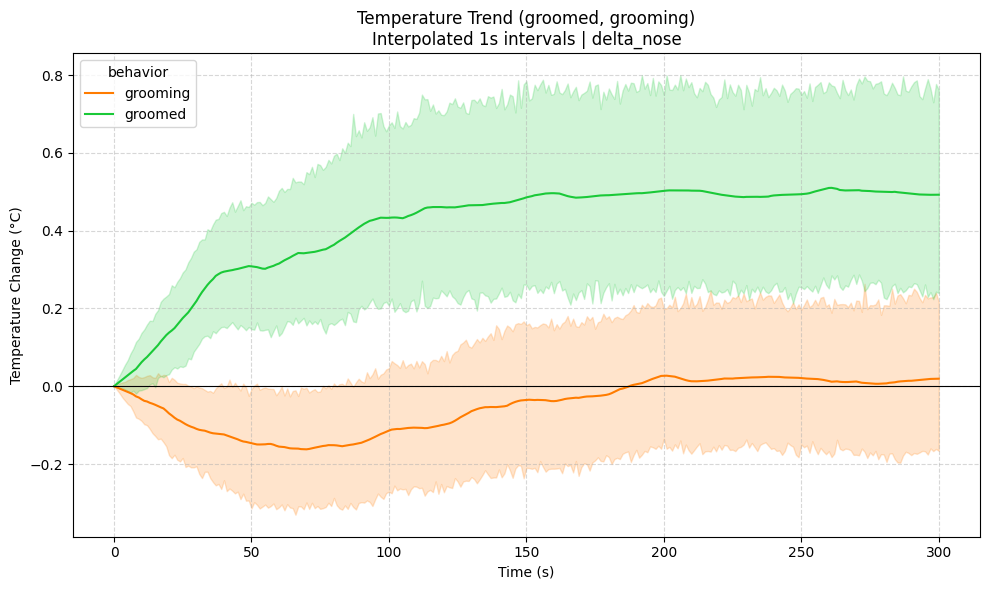

In [ ]:
self.plot_smoothed_behavior_comparison(
    delta_df_1s, y_column='delta_nose', target_behaviors=['groomed', 'grooming']
)

### behaviorでの有意差の検証

**クラスターベース置換検定**

1. 1秒ごとに $t$ 検定を行い、$t$ 値を算出します。
2. 有意な $t$ 値（|$t$| > 1.95）が連続している区間を「クラスター」とし、そのクラスター中の $t$ 値の総和（`Cluster Stat`）を計算します
3. 以下を1000回繰り返す
   - 1. `1`の過程
   - 2. `2`の過程
   - 3. `Cluster Stat`の中で最も大きいものを`Max Cluster Stat`として記録する
4. `3`で計算した`Max Cluster Stat`の分布を基に、`3`で計算した実データに基づく`Max Cluster Stat`以上の値が出る確率を計算し、これを$p$値とする

#### face

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs groomed ---
有意なクラスターは検出されませんでした。
---------------------------------------------------------


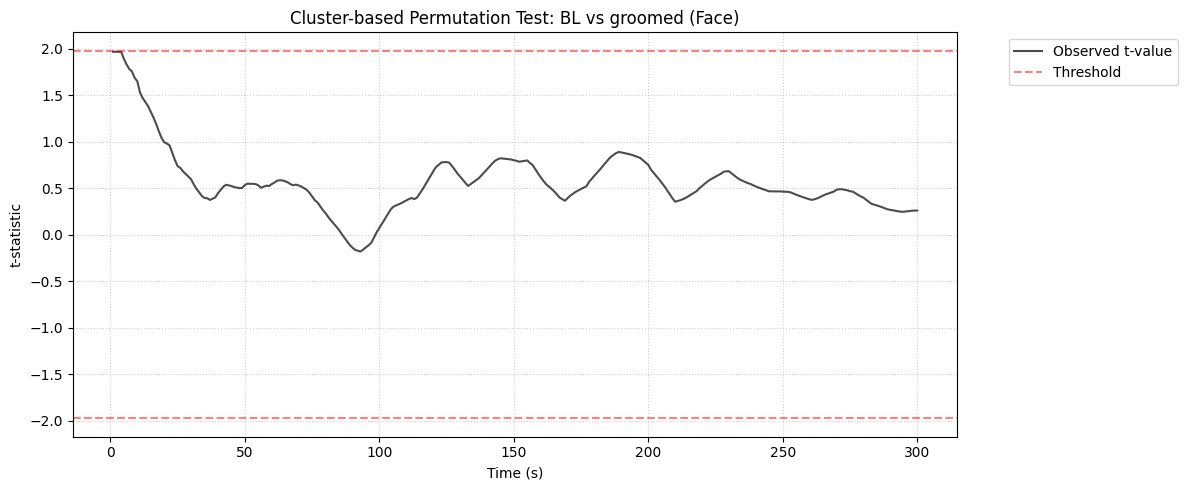

In [21]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'groomed'],
    y_column='delta_face', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs grooming ---
Cluster 1: 1s - 166s | Stat: 399.94 | p = 0.0250
  => ★ 有意 (p < 0.05)
Cluster 2: 171s - 283s | Stat: 245.76 | p = 0.0320
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


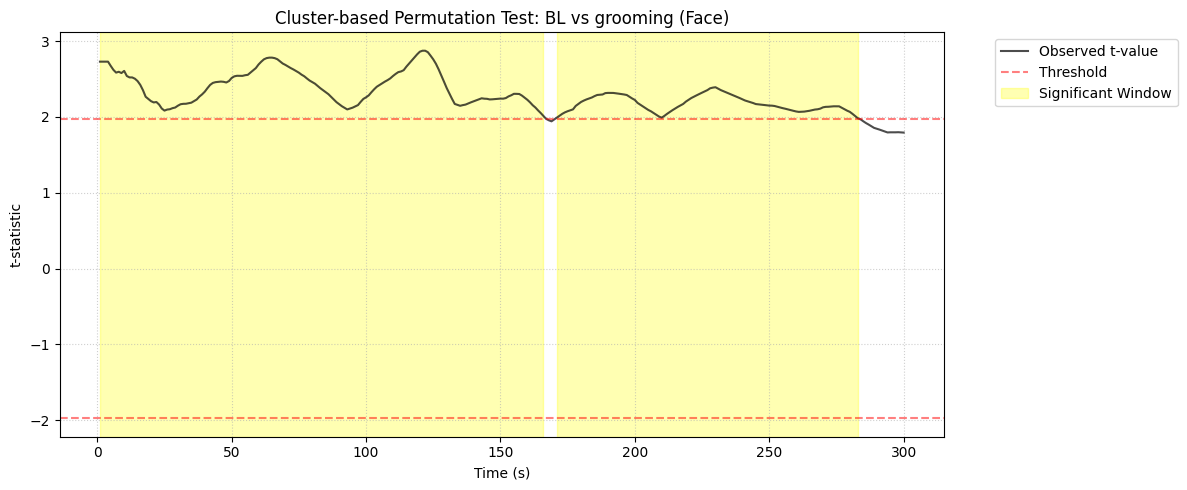

In [22]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'grooming'],
    y_column='delta_face', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: groomed vs grooming ---
Cluster 1: 24s - 145s | Stat: 334.55 | p = 0.0300
  => ★ 有意 (p < 0.05)
Cluster 2: 147s - 186s | Stat: 84.96 | p = 0.0940
  => 有意差なし
Cluster 3: 198s - 300s | Stat: 234.94 | p = 0.0460
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


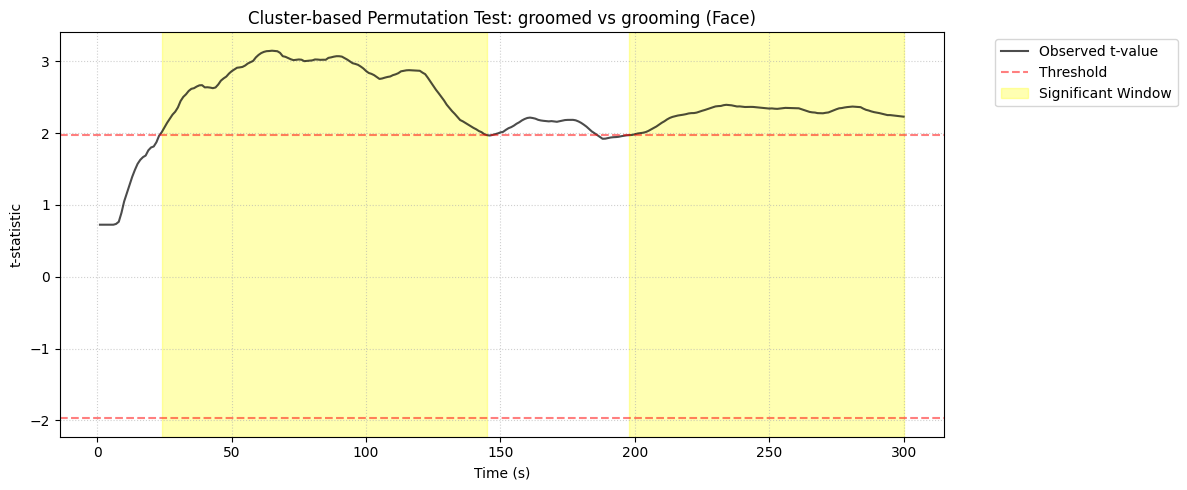

In [23]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['groomed', 'grooming'],
    y_column='delta_face', 
)

#### nose

`target_behaviors=['BL', 'groomed']`で見えている程度の小さなクラスター（一瞬しきい値を超える程度の差）であれば、全く無関係なデータを混ぜ合わせて計算しても、約11%の確率で偶然発生してしまう

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs groomed ---
Cluster 1: 28s - 52s | Stat: 54.83 | p = 0.0920
  => 有意差なし
Cluster 2: 90s - 95s | Stat: 11.94 | p = 0.1600
  => 有意差なし
---------------------------------------------------------


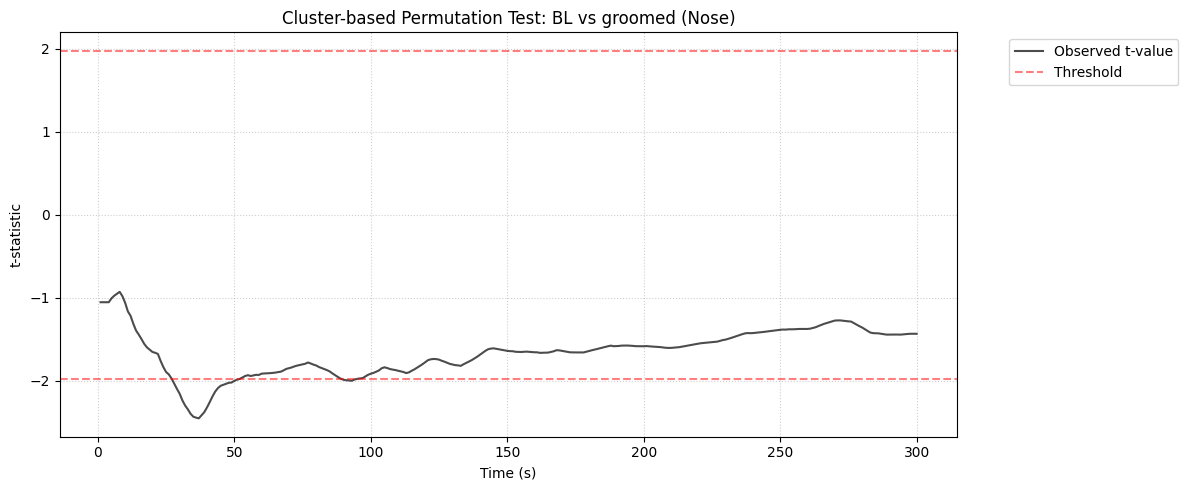

In [24]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'groomed'],
    y_column='delta_nose', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: BL vs grooming ---
有意なクラスターは検出されませんでした。
---------------------------------------------------------


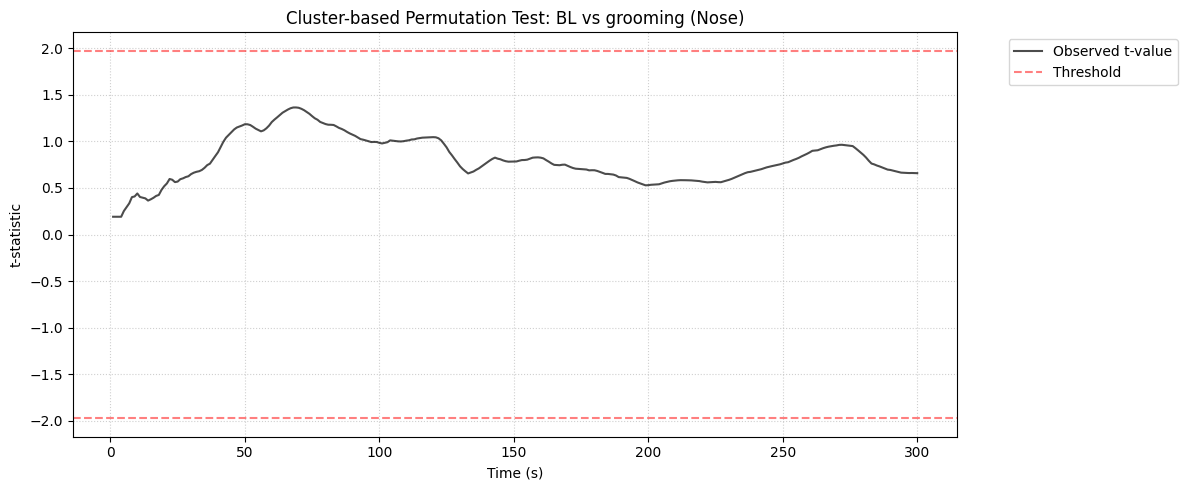

In [25]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['BL', 'grooming'],
    y_column='delta_nose', 
)

Running 1000 permutations...

--- Cluster-based Permutation Result: groomed vs grooming ---
Cluster 1: 11s - 300s | Stat: 969.48 | p = 0.0000
  => ★ 有意 (p < 0.05)
---------------------------------------------------------


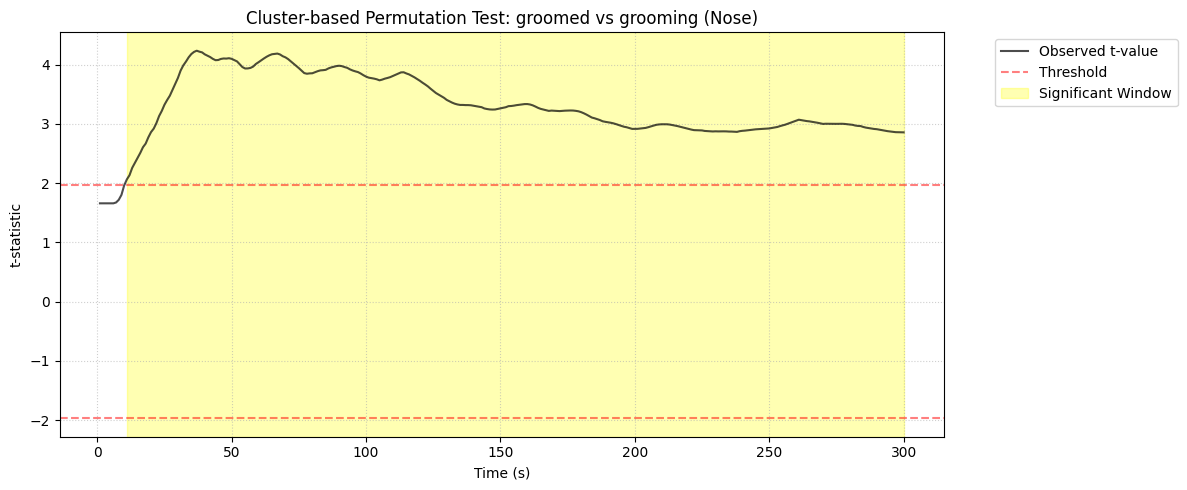

In [26]:
self.run_cluster_permutation_test(
    delta_df_1s, 
    target_behaviors=['groomed', 'grooming'],
    y_column='delta_nose', 
)